# Выращиваем решающее дерево своими руками

### AIMasters 2022, "Машинное обучение 1", Алексеев Илья Алексеевич

В этом ноутбуке вам предлагается реализовать решающее дерево.

![](figures/tree-construction.svg)

**Шаг 1.** Реализовать метод `get_threshold`: по векторам $y, f$ найти порог разбиения
1. Отсортировать объекты по $f$
2. Перебрать все пороги
3. Найти порог, максимизирующий information gain

*Примечание*. Считаем доступным метод `impurity`

In [1]:
import numpy as np

class Criterion:
    def get_threshold(self, feature, target):
        """
        Find maximum information gain by splitting
        given objects based on given feature.

        Arguments
        ---
        feature : feature vector, np.ndarray.shape = (n_samples, )
        target  : target vector, np.ndarray.shape = (n_samples, )

        Return
        ---
        threshold : value to split feature vector, float
        gain      : information gain, float
        """

        indices = np.argsort(feature)
        feature_srt = feature[indices]
        
        _, ind = np.unique(feature_srt, return_index=True)
        if len(ind) < 2:
          return None, 0
        
        N = len(feature)
        target_srt = target[indices]

        # initialize search variables
        gain_best = -np.inf
        i_best = None

        # initial impurity
        h_root = self.impurity(target)

        # greedy search for best threshold
        for i in ind[1:]:
            h_left = self.impurity(target_srt[:i])
            h_right = self.impurity(target_srt[i:])

            gain = h_root - h_left * i / N - h_right * (N - i) / N

            if gain > gain_best:
                gain_best = gain
                i_best = i

        # resulting threshold is drawn between feature values,
        # corresponding to [i_best]'th and [i_best-1]'th order statistics
        threshold = (feature_srt[i_best] + feature_srt[i_best - 1]) / 2

        return threshold, gain_best

    def impurity(self, target):
        """
        Arguments
        ---
        target : target vector, np.ndarray.shape = (n_samples, )

        Return
        ---
        float
        """

        raise NotImplementedError()

    def predict(self, target):
        raise NotImplementedError()

**Шаг 2.** Реализовать метод `predict`:
- для классификации вернуть вероятностное распределение меток
- для регрессии вернуть среднее целевое значение

In [2]:
class ClassificationCriterion(Criterion):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        
    def predict(self, target):
        """
        Arguments
        ---
        `target` : target vector, np.ndarray.shape = (n_samples, )

        Return
        ---
        probability distribution in node, np.ndarray.shape = (n_classes, )
        """
        return np.bincount(target, minlength=self.n_classes) / len(target)

In [3]:
class RegressionCriterion(Criterion):
    def predict(self, target):
        """
        Arguments
        ---
        target : target vector, np.ndarray.shape = (n_samples, )

        Return
        ---
        best constant approximation, float
        """
        return np.mean(target)

**Шаг 3.** Реализовать функции подсчета критериев  `gini`, `entropy`, `MSE`.

$$
\text{Gini}=1-\sum_{k=1}^K p_k^2
$$

$$
\text{Entropy}=-\sum_{k=1}^K p_k\log p_k
$$

$$
\text{MSE}={1\over\ell}\sum_{i-1}^\ell(y_i-\bar y)^2
$$

*Примечание.* Считаем метод `predict` доступным.

In [4]:
class GiniCriterion(ClassificationCriterion):
    def impurity(self, classes):
        pred = self.predict(classes)
        return 1 - np.sum(pred ** 2)

In [5]:
class EntropyCriterion(ClassificationCriterion):
    EPS = 1e-6

    def impurity(self, classes):
        pred = self.predict(classes)
        return -np.sum(pred * np.log(pred + self.EPS))

In [6]:
class MSECriterion(RegressionCriterion):
    def impurity(self, target):
        return np.var(target)

Тесты.

In [7]:
target = [1, 1, 2, 4, 2, 2, 0, 1, 0, 4]
y_true = [0.2, 0.3, 0.3, 0, 0.2]
y_pred = GiniCriterion(n_classes=5).predict(target)
assert np.allclose(y_pred, y_true)

In [8]:
target = [1, 1, 2, 4, 2, 2, 0, 1, 0, 4]
scores = GiniCriterion(n_classes=5).impurity(target)
assert np.isclose(scores, 0.74)

In [9]:
N = 100

x = np.arange(N)
y = np.r_[np.ones(N // 2), np.zeros(N - N // 2)].astype(int)

threshold, q_best = GiniCriterion(n_classes=2).get_threshold(x, y)
assert np.isclose(threshold, 49.5)
assert np.isclose(q_best, 0.5)

**Шаг 4.** Реализовать функцию `get_best_split`: поиск оптимального разбиения для заданного критерия.

In [10]:
def get_best_split(X, y, criterion: Criterion):
    '''
    Find best split for current node

    Argument
    ---
    X : objects in node, np.ndarray.shape = (n_samples, n_features)
    y : target values, np.ndarray.shape = (n_samples, )
    criterion : `Criterion` instance

    Return
    ---
    feature   : number of best feature to split,  int
    threshold : float
    gain_best : float
    '''

    q_best = -np.inf
    threshold = None
    feature = None

    # greedy search for best feature
    for i in range(X.shape[1]):
        thrl, q = criterion.get_threshold(X[:, i], y)
        if q > q_best:
            q_best = q
            threshold = thrl
            feature = i

    return feature, threshold, q_best

Тесты.

In [11]:
N, M = 100, 10
f = 3

criterion = GiniCriterion(n_classes=2)
x = np.c_[[np.arange(N) if f == fi else np.random.random(size=N) for fi in range(M)]].T
y = np.r_[np.ones(N // 2), np.zeros(N - N // 2)].astype(int)

In [12]:
best_feature, best_threshold, gain = get_best_split(x, y, criterion)

assert best_feature == f
assert best_threshold == 49.5
assert gain == 0.5

Вспомогательная структура данных:

In [13]:
from dataclasses import dataclass
from typing import Any

@dataclass
class TreeNode:
    impurity: float             # node impurity
    predict_val: Any            # prediction of node
    depth: int                  # current node depth

    feature = None              # feature to split
    threshold = None            # threshold to split
    gain = -np.inf              # non-terminal nodes: information gain after split
    predictions = None          # terminal nodes: probability distribution or float constant

    child_left = None
    child_right = None

def make_node(y, criterion: Criterion, depth):
    return TreeNode(
        criterion.impurity(y),
        criterion.predict(y),
        depth,
    )

Вспомогательная функция:

In [14]:
def split(node: TreeNode, X, y, criterion: Criterion):
    '''
    Arguments
    ---
    X : samples in node, np.ndarray.shape = (n_samples, n_features)
    y : target values, np.ndarray.shape = (n_samples, )
    criterion : criterion to split by, Criterion

    Return
    ---
    right_mask : indicates samples in right node after split
        np.ndarray.shape = (n_samples, )
        np.ndarray.dtype = bool

    child_left  : TreeNode
    child_right : TreeNode
    '''

    mask_right = (X[:, node.feature] > node.threshold)

    child_right = make_node(y[mask_right], criterion, node.depth + 1)
    child_left = make_node(y[~mask_right], criterion, node.depth + 1)

    return mask_right, child_left, child_right


**Шаг 5.** Реализовать общую процедуру построения дерева.

`_fit` - рекурсивная функция построения дерева. Алгоритм:
1. Проверить критерий останова
2. Определить объекты, дошедшие до текущие вершине
3. Найти оптимальный information gain
4. Проверить еще один критерий останова
5. Произвести разбиение и вызвать построение для потомков
    
`_predict` - рекурсивная функция, которая пропускает объекты через вершины и заполняет матрицу предсказаний. Алгоритм
1. Проверить, является ли вершина терминальной (да $\Rightarrow$ возвращаем предсказание, сохранённое в ней).
2. Определить объекты, дошедшие до текущие вершине
3. Вызвать функцию для потомков

Вершина не будет разветвляться, если выполнено хотя бы одно из четырех условий:
* если вершина на глубине `max_depth`
* если в вершине объектов меньше, чем `min_leaf_size`
* если в вершине все объекты имеют одинаковые метки
* если information gain меньше, чем `min_gain`

In [15]:
class DecisionTree:
    def __init__(self, max_depth=np.inf, min_leaf_size=1, min_gain=0):
        self.max_depth = max_depth
        self.min_leaf_size = min_leaf_size
        self.min_gain = min_gain

    def _fit(self, X, y, indices, node: TreeNode, criterion: Criterion):
        '''
        Builds tree recursively

        Arguments
        ---
        X : initial dataset, np.ndarray.shape = (n_samples, n_features)
        y : target values, np.ndarray.shape = (n_samples, )
        criterion : criterion to split by, Criterion
        indices : current samples indices, np.ndarray.shape = (n_samples, )
        node : current node to split, TreeNode
        '''

        # terminate construction if is needed
        if node.depth >= self.max_depth:
            node.predictions = criterion.predict(y[indices])
            return

        if len(indices) < self.min_leaf_size:
            node.predictions = criterion.predict(y[indices])
            return

        if len(np.unique(y[indices])) < 2:
            node.predictions = criterion.predict(y[indices])
            return

        # objects reached current node
        X_node = X[indices]
        y_node = y[indices]

        # maximize information gain
        feature, threshold, gain = get_best_split(X_node, y_node, criterion)

        # terminate construction if is needed
        if gain < self.min_gain:
            node.predictions = criterion.predict(y[indices])
            return

        node.feature = feature
        node.threshold = threshold
        node.gain = gain

        mask_right, child_left, child_right = split(node, X_node, y_node, criterion)
        
        node.child_left = child_left
        node.child_right = child_right

        self._fit(X, y, indices[~mask_right], child_left, criterion)
        self._fit(X, y, indices[mask_right], child_right, criterion)

    def _predict(self, X, predictions, indices, node: TreeNode):
        '''
        Descent to leaf nodes recursively and fills `predictions`

        Parameters
        ----------
        X : intial dataset, np.ndarray.shape = (n_samples, n_features)
        predictions : result matrix to fill,
            - classification : np.ndarray.shape = (n_samples, n_classes)
            - regression : np.ndarray.shape = (n_samples, )
        indices : samples' indices in node,
            np.ndarray.shape = (n_samples, )
            nd.ndarray.dtype = int
        node : current node to split, TreeNode
        '''

        if node.predictions is not None:
            predictions[indices] = node.predictions
            return

        X_node = X[indices]
        mask_right = (X_node[:, node.feature] > node.threshold)

        self._predict(X, predictions, indices[~mask_right], node.child_left)
        self._predict(X, predictions, indices[mask_right], node.child_right)

**Шаг 6.** Написать обёртки над `DecisionTree` для случая классификации и для случая регрессии.

In [16]:
from typing import Literal

class ClassificationDT(DecisionTree):
    def __init__(self, criterion: Literal['gini', 'entropy'] = 'gini', max_depth=np.inf, min_leaf_size=1, min_gain=0):
        super().__init__(max_depth, min_leaf_size, min_gain)
        
        if criterion not in ['gini', 'entropy']:
            raise ValueError('Unsupported criterion', criterion)
        
        self.criterion = criterion
            
    def fit(self, X, y):
        self.n_classes = np.max(y) + 1
        self.n_features = X.shape[1]
        
        if self.criterion == 'gini':
            criterion = GiniCriterion(self.n_classes)
        elif self.criterion == 'entropy':
            criterion = EntropyCriterion(self.n_classes)

        self.root = make_node(y, criterion, depth=0)
        self._fit(X, y, np.arange(X.shape[0]), self.root, criterion)

        return self

    def predict_proba(self, X):
        probas = np.zeros(shape=(X.shape[0], self.n_classes))
        self._predict(X, probas, np.arange(X.shape[0]), self.root)
        return probas

    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)

Тест.

In [17]:
some_tree = ClassificationDT(max_depth=2, min_leaf_size=1)

some_X = np.vstack((
    np.random.normal(loc=(-5, -5), size=(100, 2)),
    np.random.normal(loc=(-5, 5), size=(100, 2)),
    np.random.normal(loc=(5, -5), size=(100, 2)),
    np.random.normal(loc=(5, 5), size=(100, 2)),
))

some_y = np.array(
    [0] * 100 + [1] * 100 + [2] * 100 + [3] * 100
)

some_tree.fit(some_X, some_y)
predictions = some_tree.predict(some_X)

In [18]:
some_X.shape, some_y.shape

((400, 2), (400,))

In [19]:
assert isinstance(predictions, type(np.zeros(0)))
assert (predictions == some_y).all()

In [20]:
some_tree = ClassificationDT(max_depth=2, min_leaf_size=1)

some_X = np.vstack((
    np.random.normal(loc=(-5, -5), size=(100, 2)),
    np.random.normal(loc=(-5, 5), size=(100, 2)),
    np.random.normal(loc=(5, -5), size=(100, 2)),
    np.random.normal(loc=(5, 5), size=(100, 2)),
))

some_X = np.hstack((some_X, np.random.random((400, 100))))

some_y = np.array(
    [0] * 100 + [1] * 100 + [2] * 100 + [3] * 100
)

some_tree.fit(some_X, some_y)
predictions = some_tree.predict(some_X)

assert isinstance(predictions, type(np.zeros(0)))
assert (predictions == some_y).all()

Визуализируем.

In [21]:
import matplotlib.pyplot as plt

def plot_classification(clf, X, y, plot_step=0.2, cmap='Spectral', figsize=(6, 5)):
    plt.figure(figsize=figsize)
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)
    y_pred = clf.predict(X)

    # Plot the training points
    plt.scatter(*X[y_pred == y].T, marker='.', s=70,
                c=y[y_pred == y], cmap=cmap, alpha=0.9, label='correct')
    plt.scatter(*X[y_pred != y].T, marker='x', s=50,
                c=y[y_pred != y], cmap=cmap, label='errors')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis("tight")
    plt.legend(loc='best')
    print("Accuracy =", np.mean(y == y_pred))

In [22]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, n_features=2, cluster_std=1, centers=4, random_state=0)

Accuracy = 0.4766666666666667


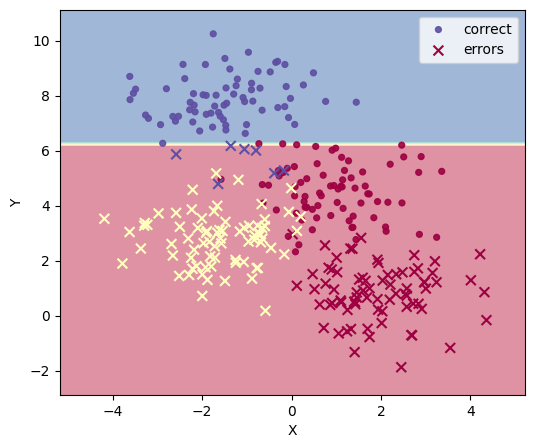

In [23]:
clf = ClassificationDT(max_depth=1, min_leaf_size=3)
clf.fit(X, y)
plot_classification(clf, X, y)

Accuracy = 0.71


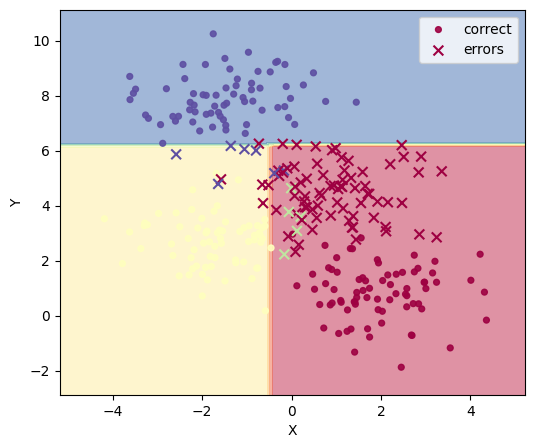

In [24]:
clf = ClassificationDT(max_depth=2, min_leaf_size=3)
clf.fit(X, y)
plot_classification(clf, X, y)

Accuracy = 0.94


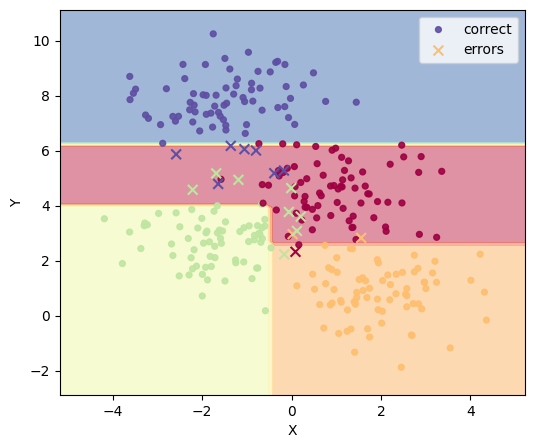

In [25]:
clf = ClassificationDT(max_depth=3, min_leaf_size=3)
clf.fit(X, y)
plot_classification(clf, X, y)

In [26]:
class RegressionDT(DecisionTree):
    def __init__(self, criterion='mse', max_depth=np.inf, min_leaf_size=1, min_gain=0):
        super().__init__(max_depth, min_leaf_size, min_gain)
        
        if criterion not in ['mse']:
            raise ValueError('Unsupported criterion', criterion)
        
        self.criterion = criterion
            
    def fit(self, X, y):
        self.n_features = X.shape[1]
        
        if self.criterion == 'mse':
            criterion = MSECriterion()

        self.root = make_node(y, criterion, depth=0)
        self._fit(X, y, np.arange(X.shape[0]), self.root, criterion)

        return self
    
    def predict(self, X):
        values = np.zeros(X.shape[0])
        self._predict(X, values, np.arange(X.shape[0]), self.root)
        return values

Тесты.

In [27]:
def make_regression(func, a, b, n_samples, noise):
    X = np.linspace(a, b, n_samples)
    y = func(X) + np.random.normal(scale=noise, size=n_samples)
    return X[:, None], y

In [33]:
import seaborn as sns
sns.set(palette='deep', style='darkgrid')
import matplotlib.pyplot as plt

def plot_regression(reg: RegressionDT, X, y, step_count=100, figsize=(6, 5)):
    plt.figure(figsize=figsize)

    reg.fit(X, y)
    y_pred = reg.predict(X)
    xmin, xmax = X.min(), X.max()
    x_test = np.linspace(xmin, xmax, step_count).reshape(-1, 1)
    y_test = reg.predict(x_test)

    plt.plot(x_test, y_test, label='Predicted', alpha=0.75)
    plt.scatter(X, y, marker='.', s=50, label='Sample', c='indigo')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis("tight")
    plt.legend(loc='best')
    plt.title(f'max depth: {reg.max_depth}')
    print('MSE =', np.mean((y - y_pred) ** 2))

In [34]:
X, y = make_regression(np.sin, a=-np.pi, b=np.pi, n_samples=50, noise=0.2)

MSE = 0.12921341813842083


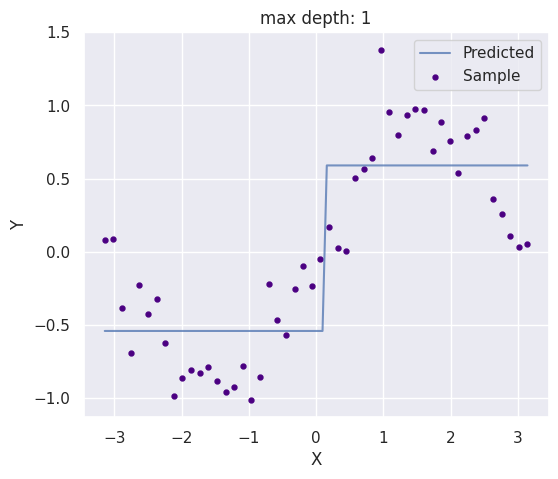

In [35]:
reg = RegressionDT(max_depth=1)
plot_regression(reg, X, y)

MSE = 0.037877692522253856


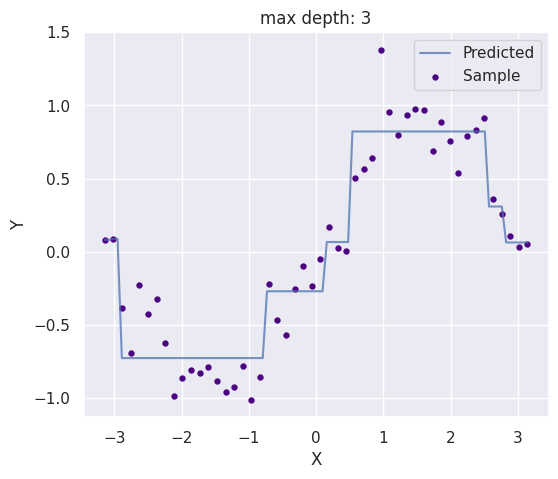

In [36]:
reg = RegressionDT(max_depth=3)
plot_regression(reg, X, y)

MSE = 0.0


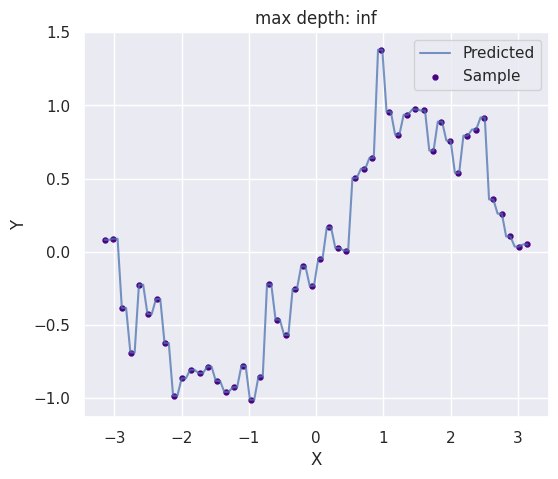

In [39]:
reg = RegressionDT()
plot_regression(reg, X, y)